### PROD MODELS
distil-whisper-large-v3-en, gemma2-9b-it, llama-3.3-70b-versatile, llama-3.1-8b-instant, llama-guard-3-8b, llama3-70b-8192, llama3-8b-8192
mixtral-8x7b-32768, whisper-large-v3,whisper-large-v3-turbo
### PREVIEW MODELS
deepseek-r1-distill-llama-70b, llama-3.3-70b-specdec, llama-3.2-1b-preview, llama-3.2-3b-preview, llama-3.2-11b-vision-preview, llama-3.2-90b-vision-preview

In [1]:

import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")





In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': "LangGraph's underlying graph algorithm uses message passing to define a general program. When a Node completes its operation, it sends messages along one or more edges to other node (s). These recipient nodes then execute their functions, pass the resulting messages to the next set of nodes, and the process continues."},
 {'url': 'https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5',
  'content': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges | by Story_Teller | Dec, 2024 | Medium LangGraph Basics: Understanding State, Schema, Nodes, and Edges LangGraph Basics: Understanding State, Schema, Nodes, and Edges These predefined structures in the messaging app are synonymous with the schema of the state in LangGraph. Just as a messaging app ensures all interactions (messages) follow a consistent format, the schema in LangGraph ensures the

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

llm_with_tool = llm.bind_tools(tools)

In [4]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]



In [6]:

graph_builder = StateGraph(State)

In [7]:

def chatbot(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}


In [8]:


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)


In [9]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [10]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

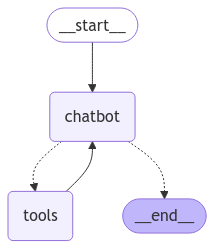

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


In [12]:
config = {"configurable": {"thread_id": "1"}}

In [13]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Nice to meet you, Will!


In [14]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Nice to meet you, Will!


In [17]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm not familiar with your name.


In [18]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='a570f55d-7769-4641-a0a3-0acda2d07131'), AIMessage(content='Nice to meet you, Will!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 947, 'total_tokens': 955, 'completion_time': 0.006666667, 'prompt_time': 0.120911113, 'queue_time': 0.033872741, 'total_time': 0.12757778}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-06c2b1ec-bfe3-4601-a15b-2d3755ad29ca-0', usage_metadata={'input_tokens': 947, 'output_tokens': 8, 'total_tokens': 955}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='1ef8c442-0131-48c4-846d-53070054d5c0'), AIMessage(content='Nice to meet you, Will!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 1956, 'total_tokens': 1964

In [19]:
snapshot.next

()

In [18]:

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_16.pdf", "content": "Introduction Quantum Approximation Optimization Algorithm (QAOA) is one of the algorithms that can be implemented in the near-term quantum computer and regarded as one of the most promising algorithms to demonstrate quantum supremacy. QAOA is an approximation algorithm which means it does not deliver the `best' result, but only the `good enough' result, which is characterized by a lower bound"}, {"url": "https://arxiv.org/pdf/2306.09198", "content": "The Quantum Approximate Optimization Algorithm (QAOA) is a highly promising variational quantum algorithm that aims to solve combinatorial optimization problems that are classically in-tractable. This comprehensive review ofers an overview of the current state of QAOA, encompassing its performance analysis in diverse scenarios, its applicability across various problem instances, and"}]
Assistant: Based on the provided informat